# Singleモデルにおける画像の埋め込みとtopK計算用

In [1]:
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import load_model

/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

In [3]:
import os
BASE_PATH = './dataset/crop_img/img/TOPS/Coat/'

In [4]:
model_epoch = 99
ALPHA = 0.1
BETA = 0.05
vec_length = 512
category = 'Coat'

In [5]:
# model_dir = './model/{}/Single_improved/a{}b{}/{}'.format(category,ALPHA,BETA,vec_length)
# model_dir = './model/{}/Single_normal/a{}/{}'.format(category,ALPHA,vec_length)
model_dir = './model/{}/Single_improved/a{}b{}/{}'.format(category,ALPHA,BETA,vec_length)
# os.listdir(model_dir)

In [6]:
con_embNet = load_model(model_dir+'/con_e{}.h5'.format(model_epoch), compile=False)
shop_embNet = load_model(model_dir+'/shop_e{}.h5'.format(model_epoch), compile=False)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# con_embNet = load_model(model_dir+'/con_emb_e{}.h5'.format(model_epoch), compile=False)
# shop_embNet = load_model(model_dir+'/shop_emb_e{}.h5'.format(model_epoch), compile=False)

生成済みのpickleを利用するため`datagen.py`は使わない

In [8]:
f = open("./pickle/{}/test_pairs.pickle".format(category),"rb")
test_pairs = pickle.load(f)

In [9]:
test_pairs[0]

[5723,
 ['./dataset/crop_img/img/TOPS/Coat/id_00005723/comsumer_01.jpg',
  './dataset/crop_img/img/TOPS/Coat/id_00005723/shop_01.jpg']]

In [10]:
gallery = []
for tp in test_pairs:
    gallery.append([tp[0],tp[1][1]])

In [11]:
print(gallery[0])
print('gallery length = {}'.format(len(gallery)))

[5723, './dataset/crop_img/img/TOPS/Coat/id_00005723/shop_01.jpg']
gallery length = 803


In [12]:
emb_vecs = np.zeros((len(gallery),vec_length))
ans_ids = np.zeros(len(gallery))
print(emb_vecs.shape)
print(ans_ids.shape)

(803, 512)
(803,)


In [13]:
for i,g in enumerate(tqdm(gallery)):
    img =np.array(Image.open(g[1]).resize((128,128)).convert('RGB'))/255.
    ans_ids[i] = g[0]
    emb_vecs[i] = shop_embNet.predict(np.expand_dims(img,axis=0))[0]

100%|██████████| 803/803 [00:07<00:00, 144.32it/s]


In [14]:
f = open(model_dir+'/gallery{}.txt'.format(model_epoch),'wb')
pickle.dump(emb_vecs,f)

In [15]:
def euclid_dist(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [16]:
query_ids = np.zeros(len(test_pairs))
print(query_ids.shape)

(803,)


In [17]:
for i,tp in enumerate(test_pairs):
    query_ids[i] = tp[0]
query_ids[:5]

array([ 5723., 27925.,  6960.,  6414.,  1391.])

In [18]:
N = 50

In [19]:
topN_id_list = []
query_emb_vecs = np.zeros((len(gallery),vec_length))
for i,tp in enumerate(tqdm(test_pairs)):
    img = np.array(Image.open(tp[1][0]).resize((128,128)).convert('RGB'))/255.
    query_emb = con_embNet.predict([np.expand_dims(img.astype(np.float32),axis=0)])[0]
    query_emb_vecs[i] = query_emb
    # calculation
    similarities = np.zeros(len(gallery))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = euclid_dist(query_emb,emb_vec)
    # argsort
    idxs = similarities.argsort()
    topN_id_list.append(ans_ids[idxs[:N]])  

100%|██████████| 803/803 [00:10<00:00, 78.97it/s]


In [20]:
topN_id_list[0]

array([ 5723.,   282.,  4418., 15684.,  9316., 27528.,  6295.,  6087.,
        1664., 10468.,  5343.,  3996., 10065., 32710.,  3783.,  5472.,
        3767.,  6920.,  4343.,  6002.,  6196.,  7331., 18354.,  7016.,
       12721., 14416., 15615.,  7394., 18959., 16085.,  8896.,  8489.,
       14993., 18992., 13443.,  4944.,  8276.,  4177., 12401.,  4765.,
        8775.,   308., 17977.,  1215.,  8912.,  5573., 10040., 12956.,
       16309.,  2263.])

In [21]:
f = open(model_dir+'/topN_id_list{}.txt'.format(model_epoch),'wb')
pickle.dump(topN_id_list,f)

In [22]:
f = open(model_dir+'/query{}.txt'.format(model_epoch),'wb')
pickle.dump(query_emb_vecs,f)

In [23]:
def calc_topk_vals(k_values,ans_ids,topN_id_list):
    topk_vals = []
    for k in k_values:
        cnt = 0
        for i,(ans_id,topN_id) in enumerate(zip(ans_ids,topN_id_list)):
            if ans_id in topN_id[:k]:
                cnt+=1
        topk_vals.append(cnt/len(ans_ids))
    return topk_vals

In [24]:
x = list(range(1,51))
topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)

In [25]:
f = open(model_dir+'/topk_vals.txt'.format(model_epoch), 'wb')
pickle.dump(topk_vals, f)

In [26]:
topk_vals

[0.014943960149439602,
 0.024906600249066,
 0.038605230386052306,
 0.048567870485678705,
 0.058530510585305104,
 0.06724782067247821,
 0.0722291407222914,
 0.07970112079701121,
 0.08468244084682441,
 0.0921544209215442,
 0.10087173100871731,
 0.1133250311332503,
 0.12204234122042341,
 0.1295143212951432,
 0.1320049813200498,
 0.1382316313823163,
 0.14196762141967623,
 0.14819427148194272,
 0.15442092154420922,
 0.16313823163138233,
 0.16936488169364883,
 0.17434620174346202,
 0.1793275217932752,
 0.1843088418430884,
 0.18929016189290163,
 0.1930261519302615,
 0.1980074719800747,
 0.20298879202988793,
 0.21419676214196762,
 0.21793275217932753,
 0.22166874221668742,
 0.22789539227895392,
 0.22914072229140722,
 0.23661270236612703,
 0.24159402241594022,
 0.25280199252801994,
 0.25529265255292655,
 0.2602739726027397,
 0.2627646326276463,
 0.2714819427148194,
 0.28144458281444584,
 0.28393524283935245,
 0.2876712328767123,
 0.29140722291407223,
 0.29265255292652553,
 0.29763387297633875,


/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


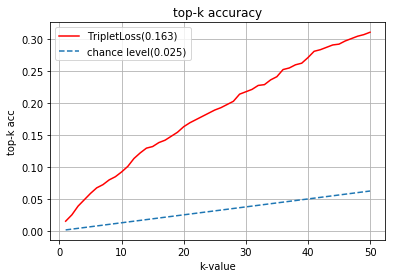

In [27]:
x = list(range(1,51))
chancelv=np.array(x)/len(test_pairs)

topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)
plt.plot(x,topk_vals,c='r',label='TripletLoss({})'.format(round(topk_vals[19],3)))
# plt.plot(x,topk_vals,c='r',marker='o',label='improvedTripletLoss({})'.format(round(topk_vals[4],3)))
plt.plot(x,chancelv,linestyle='dashed',label='chance level({})'.format(round(chancelv[19],3)))

# graph settings
plt.legend(loc='best')#,bbox_to_anchor=(1, 0.2))
plt.grid('True')
plt.title("top-k accuracy")
plt.xlabel("k-value")
plt.ylabel("top-k acc")
plt.show()